# Prediction

Having collected, cleaned and organized the data with information about ratings, cast, genre and past Oscar performances, we will now try to predict the winners and nominees. The approach that we take is the following. 

Because we have seen that a movie almost has to be in one of the three major categories -- drama, romance, comedy or biograpjy -- we will filter our data to only consider the movie that fall into oine of thes egenres. 
We will then use a variety of different models to predict the probabibility of win for the different movies. The movies will be sorted in descending order of win probabilities. 

Finally, we will take a aweighted average of al the prediction, weighted by the recall score, and use the grand average as our final prediction. 

In [1]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline

# scikit learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score


In [2]:
DF_main = pd.read_csv('my_data/df_main_FINAL.csv', index_col=[0])
all_genres = pickle.load(open("my_data/all_genres_FINAL","rb"))
oscar_categories = pickle.load(open("my_data/major_oscar_categories","rb"))
oscar_genres_columns = ['sci-fi', 'family', 'adventure', 'crime', 
                'biography', 'history', 'musical', 'romance', 'sport', 'comedy', 
                'horror', 'drama', 'mystery', 'war', 'thriller']



ID_columns = ['imdbID', 'title', 'year']
basic_columns = ['cast_size', 'genre_span']

    
print("Oscar genres:\n",oscar_genres_columns)
print("Oscar categories:\n", oscar_categories)



scores = ['n_votes','imdb_rating', 'metscore', 'rotten_tomatoes']
awards_pre = ['precount_wins', 'precount_noms', 'other_wins', 'other_noms']
awards_post = ['win', 'nom']

predictor_columns = basic_columns + oscar_genres_columns + scores + awards_pre

print("Predictor columns:\n",predictor_columns)
target_columns = ['win', 'nom']
filters = ((DF_main.drama==1)|((DF_main.comedy==1)|(DF_main.romance==1)|(DF_main.biography==1)))&(DF_main.action==0)
DF_main = DF_main[filters]


Oscar genres:
 ['sci-fi', 'family', 'adventure', 'crime', 'biography', 'history', 'musical', 'romance', 'sport', 'comedy', 'horror', 'drama', 'mystery', 'war', 'thriller']
Oscar categories:
 ['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay']
Predictor columns:
 ['cast_size', 'genre_span', 'sci-fi', 'family', 'adventure', 'crime', 'biography', 'history', 'musical', 'romance', 'sport', 'comedy', 'horror', 'drama', 'mystery', 'war', 'thriller', 'n_votes', 'imdb_rating', 'metscore', 'rotten_tomatoes', 'precount_wins', 'precount_noms', 'other_wins', 'other_noms']


In [3]:
print(f'{len(DF_main.query("year == 2019"))} 2019 movies are being considered:\n')
# print(list(DF_main.query("year == 2019").title))

192 2019 movies are being considered:



In [4]:
def convert_to_pctile(X, columns):
    
    for col in columns:
        x = np.array(X[col])
        X[col] = [(len(np.where(x<=y)[0])/len(x)) for y in x]
    return X

def normalize_by_max(X, columns):
    for col in columns:
        x = np.array(X[col])
        mx = np.max(x)
        X[col] = x/mx
    return X

def top_N_each_year(df,N,feature):
    df_ = pd.DataFrame()
    for year in list(set(df.year)):
        # print(year)
        df_ = df_.append(df[df.year == year].sort_values(by = feature, ascending=False).head(N))
    return df_

def normalize_by_year(df, columns, _how = 'max'):
    
    if type(columns)!= list:
        print("columns must be list")
        return dict()
    years = list(set(df.year))

    print(years)
    
    if _how == 'pctile':
        df = convert_to_pctile(df, columns)
        return df

    for column in columns:
        cols = ['year'] + [column]
        for year in years:
            if year%10 == 0:
                clear_output() 
            print(year, column)
            temp_df = df[(df.year == year)]
            temp_df = temp_df[column]
            ids = temp_df.index
            
            if _how == 'max':
                df.loc[ids,column] = df.loc[ids,column]/temp_df.max()
            if _how == 'minmax':
                min_max_scaler = preprocessing.MinMaxScaler()
                vals = df.loc[ids,column].values
                # vals.shape = (len(vals),1)
                print(vals.shape)
                vals = vals[:,np.newaxis]
                print(vals.shape)
                scaled_array = min_max_scaler.fit_transform(vals)
                df.loc[ids,column] = scaled_array
            
                
    return df

In [5]:
print(predictor_columns)

['cast_size', 'genre_span', 'sci-fi', 'family', 'adventure', 'crime', 'biography', 'history', 'musical', 'romance', 'sport', 'comedy', 'horror', 'drama', 'mystery', 'war', 'thriller', 'n_votes', 'imdb_rating', 'metscore', 'rotten_tomatoes', 'precount_wins', 'precount_noms', 'other_wins', 'other_noms']


In [6]:
print(DF_main.columns)
normalize_columns = ['n_votes', 'imdb_rating', 'metscore', 'rotten_tomatoes',
                     'cast_size', 'genre_span', 'cast_size', 'running_time']
DF = normalize_by_year(DF_main, predictor_columns, 'max')
DF.fillna('0',inplace=True)
# DF = normalize_by_year(DF_main, normalize_columns, 'max')

2010 other_noms
2011 other_noms
2012 other_noms
2013 other_noms
2014 other_noms
2015 other_noms
2016 other_noms
2017 other_noms
2018 other_noms
2019 other_noms


In [7]:
# DF = DF[(DF.year >=1960)&(DF.year < 2019)]
# DFX = DF.loc[:,ID_columns + predictor_columns + target_columns]
# print(ID_columns + predictor_columns + target_columns)
# DFX.columns
# DFX.info()

In [8]:
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)

X_2019 shape: (192, 25)


In [9]:
# Pre 2019 (predictor) movies

# Predictor matrix
DF1 = DF[(DF.year >=1960)&(DF.year < 2019)]
DFX = DF1.loc[:,ID_columns + predictor_columns + target_columns]
X = DFX[predictor_columns]
print("X shape:",X.shape)


#Target matrix
awards_map = {'W':1, 'N':1, 'WN':1, 'O':0}
category = 'picture'
y = DF1[category].map(awards_map).values
y = y[:,np.newaxis]
print("y shape:", y.shape)


# y = (DFX.win > 1)|(DFX.nom>3) # 2 wins of 4 nominations
# y = np.array([int(z) for z in y])
# DFX['target'] = y
# y = y[:,np.newaxis]
# print("y shape:", y.shape)

# Now for 2019 (target) movies
DFX_2019 = DF[DF.year == 2019]
DFX_2019 = DFX_2019.loc[:,ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )



X shape: (8981, 25)
y shape: (8981, 1)
X_2019 shape: (192, 25)
Class 0: 6082
Class 1: 204
2019:


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8981 entries, 0 to 13933
Data columns (total 25 columns):
cast_size          8981 non-null float64
genre_span         8981 non-null float64
sci-fi             8981 non-null object
family             8981 non-null object
adventure          8981 non-null float64
crime              8981 non-null object
biography          8981 non-null float64
history            8981 non-null object
musical            8981 non-null float64
romance            8981 non-null float64
sport              8981 non-null object
comedy             8981 non-null float64
horror             8981 non-null object
drama              8981 non-null float64
mystery            8981 non-null object
war                8981 non-null object
thriller           8981 non-null object
n_votes            8981 non-null float64
imdb_rating        8981 non-null float64
metscore           8981 non-null float64
rotten_tomatoes    8981 non-null float64
precount_wins      8981 non-null float64

In [11]:
name = []
accuracy = []
recall = []
precision = []

# Logistic Regression

Because we are interested in obtaining probabilities for each film earning a nomination, and inferring the winner from these probabilities, the only linear model that was considered was Logistic Regression. Because Logistic regression uses the logistic function to model a binary dependent variable, the output of the model can be naturally interpreted as the probability of nomination or not. 

{'C': 7.742636826811269, 'penalty': 'l2'}
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99      2607
     class 1       0.72      0.55      0.62        88

    accuracy                           0.98      2695
   macro avg       0.85      0.77      0.80      2695
weighted avg       0.98      0.98      0.98      2695

Confusion Matrix:
 [[2588   19]
 [  40   48]]
Accuracy: 0.9817392272575437
Precision: 0.7164179104477612
['logreg'] [0.9817392272575437] [0.7164179104477612]


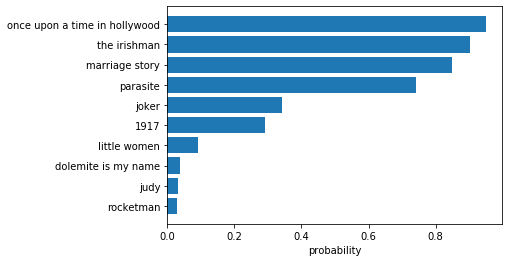

In [12]:
log = LogisticRegression(random_state=0)
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
log_cv = GridSearchCV(log, hyperparameters, cv=5, verbose=0)
log_cv.fit(X, y)
y_pred = log_cv.predict(X_2019)
y_prob = log_cv.predict_proba(X_2019)[:,1]
DFX_2019.loc[:,'predicted_probability_log'] = y_prob
x = DFX_2019.sort_values(by='predicted_probability_log', ascending=False).head(10)
clear_output()

### Performance evaluation
log_cv.fit(X_train, y_train)
y_pred = log_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(log_cv.best_params_)

plt.barh(x['title'], x['predicted_probability_log'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

acc_score = log_cv.score(X, y)
prec_score = precision_score(y_test, y_pred, labels= 'class 1')
print("Accuracy:", acc_score)
print("Precision:",prec_score)
name.append('logreg')
precision.append(prec_score)
accuracy.append(acc_score)
print(name, accuracy, precision)

In [13]:
# name.append('log')
# accuracy.append(0.96)
# recall.append(0.25)
# precision.append(0.58)
# print(name, accuracy, recall, precision)

## K Nearest neighbors classifier 
K nearest neighbor is a nonlinear classifier that provided straightforward approach to classify movies based on their proximity to previous winners and nominees. We used GridSearchCV() method from the utils package of scikit-learn module. Although several variations were available, we only performed grid search on the number parameters, whose optimal value was found to be 15. 

{'n_neighbors': 3}
0.980625765504955
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.98      2607
     class 1       0.58      0.34      0.43        88

    accuracy                           0.97      2695
   macro avg       0.78      0.67      0.71      2695
weighted avg       0.96      0.97      0.97      2695

Confusion Matrix:
 [[2585   22]
 [  58   30]]
Accuracy: 0.980625765504955
Precision: 0.5769230769230769
['logreg', 'knn'] [0.9817392272575437, 0.980625765504955] [0.7164179104477612, 0.5769230769230769]


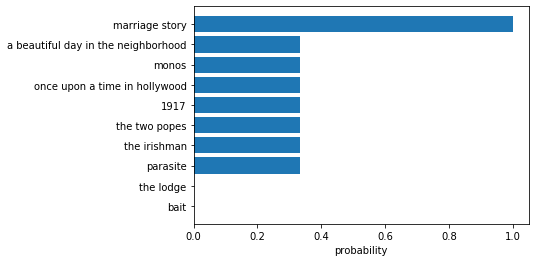

In [14]:
# KNN Training
knn = KNeighborsClassifier(n_neighbors=5)
param_grid = {'n_neighbors': np.arange(1, 30)} 
knn_cv = GridSearchCV(knn, param_grid, cv=5) 
# knn.fit(X, y) 
knn_cv.fit(X, y)

# KNN prediction
y_pred = knn_cv.predict(X_2019)
y_prob = knn_cv.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_knn'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_knn', ascending=False).head(10)
clear_output()


### Performance evaluation
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(knn_cv.best_params_)
print(knn_cv.score(X, y))
plt.barh(x['title'], x['predicted_probability_knn'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


acc_score = knn_cv.score(X, y)
prec_score = precision_score(y_test, y_pred, labels= 'class 1')
print("Accuracy:", acc_score)
print("Precision:",prec_score)
name.append('knn')
precision.append(prec_score)
accuracy.append(acc_score)
print(name, accuracy, precision)


# Random Forest Classifier

{'n_estimators': 60}
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99      2607
     class 1       0.68      0.45      0.54        88

    accuracy                           0.98      2695
   macro avg       0.83      0.72      0.77      2695
weighted avg       0.97      0.98      0.97      2695

Confusion Matrix:
 [[2588   19]
 [  48   40]]
Accuracy: 0.9923171139071373
Precision: 0.6779661016949152
['logreg', 'knn', 'rfc'] [0.9817392272575437, 0.980625765504955, 0.9923171139071373] [0.7164179104477612, 0.5769230769230769, 0.6779661016949152]


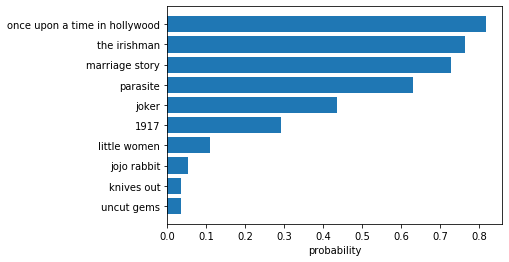

In [15]:
rfc=RandomForestClassifier() # n_estimators=100)
param_grid = {'n_estimators': np.arange(50,100,5)} 
rfc_cv = GridSearchCV(rfc, param_grid, cv=5) 

rfc_cv.fit(X,y)
y_pred = rfc_cv.predict(X_2019)
y_prob = rfc_cv.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_rfc'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_rfc', ascending=False).head(10)

### Performance evaluation
rfc_cv.fit(X_train, y_train)
y_pred = rfc_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(rfc_cv.best_params_)
plt.barh(x['title'], x['predicted_probability_rfc'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


acc_score = rfc_cv.score(X, y)
prec_score = precision_score(y_test, y_pred, labels= 'class 1')
print("Accuracy:", acc_score)
print("Precision:",prec_score)
name.append('rfc')
precision.append(prec_score)
accuracy.append(acc_score)
print(name, accuracy, precision)



# Ensemble Methods: Bag of KNN

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99      2607
     class 1       0.76      0.28      0.41        88

    accuracy                           0.97      2695
   macro avg       0.87      0.64      0.70      2695
weighted avg       0.97      0.97      0.97      2695

Confusion Matrix:
 [[2599    8]
 [  63   25]]
Accuracy: 0.9766173031956352
Precision: 0.7575757575757576
['logreg', 'knn', 'rfc', 'bag'] [0.9817392272575437, 0.980625765504955, 0.9923171139071373, 0.9766173031956352] [0.7164179104477612, 0.5769230769230769, 0.6779661016949152, 0.7575757575757576]


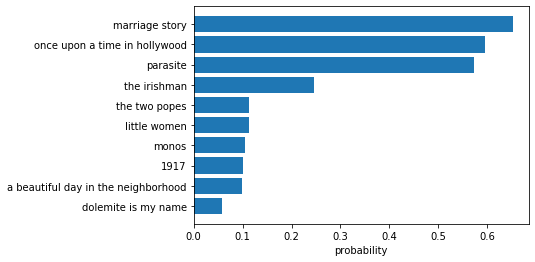

In [16]:
bag = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10), n_estimators=100, random_state=42)
bag.fit(X, y)
y_pred = bag.predict(X_2019)
y_prob = bag.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_bag'] = y_prob[:,1]
clear_output()
x = DFX_2019.sort_values(by='predicted_probability_bag', ascending=False).head(10)


### Performance evaluation
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
# print(bag.best_params_)
plt.barh(x['title'], x['predicted_probability_bag'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


acc_score = bag.score(X, y)
prec_score = precision_score(y_test, y_pred, labels= 'class 1')
print("Accuracy:", acc_score)
print("Precision:",prec_score)
name.append('bag')
precision.append(prec_score)
accuracy.append(acc_score)
print(name, accuracy, precision)


# Adaptive Boosting (Adaboost)

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      2607
     class 1       0.65      0.60      0.62        88

    accuracy                           0.98      2695
   macro avg       0.82      0.80      0.81      2695
weighted avg       0.98      0.98      0.98      2695

Confusion Matrix:
 [[2578   29]
 [  35   53]]
Accuracy: 0.9841888431132391
Precision: 0.6463414634146342
['logreg', 'knn', 'rfc', 'bag', 'ada'] [0.9817392272575437, 0.980625765504955, 0.9923171139071373, 0.9766173031956352, 0.9841888431132391] [0.7164179104477612, 0.5769230769230769, 0.6779661016949152, 0.7575757575757576, 0.6463414634146342]


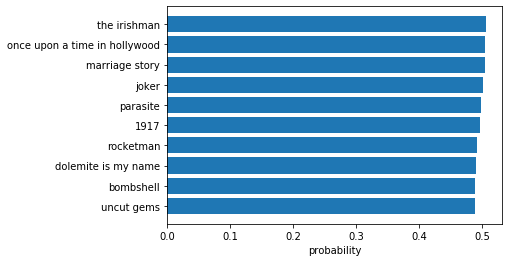

In [17]:
ada = AdaBoostClassifier(n_estimators=100, random_state=47)
ada.fit(X, y)
y_pred = ada.predict(X_2019)
y_prob = ada.predict_proba(X_2019)

DFX_2019.loc[:,'predicted_probability_ada'] = y_prob[:,1]
clear_output()
print(ada.score(X,y))
x = DFX_2019.sort_values(by='predicted_probability_ada', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]


### Performance evaluation
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
# print(ada.best_params_)
plt.barh(x['title'], x['predicted_probability_ada'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

acc_score = ada.score(X, y)
prec_score = precision_score(y_test, y_pred, labels= 'class 1')
print("Accuracy:", acc_score)
print("Precision:",prec_score)
name.append('ada')
precision.append(prec_score)
accuracy.append(acc_score)
print(name, accuracy, precision)


# Neural Network

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      2607
     class 1       0.71      0.64      0.67        88

    accuracy                           0.98      2695
   macro avg       0.85      0.81      0.83      2695
weighted avg       0.98      0.98      0.98      2695

Confusion Matrix:
 [[2584   23]
 [  32   56]]
Accuracy: 0.9799576884534016
Precision: 0.7088607594936709
['logreg', 'knn', 'rfc', 'bag', 'ada', 'mlp'] [0.9817392272575437, 0.980625765504955, 0.9923171139071373, 0.9766173031956352, 0.9841888431132391, 0.9799576884534016] [0.7164179104477612, 0.5769230769230769, 0.6779661016949152, 0.7575757575757576, 0.6463414634146342, 0.7088607594936709]


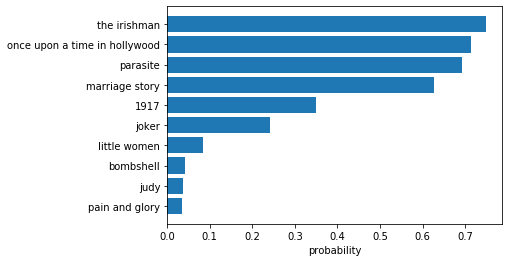

In [18]:
mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10,10), max_iter=1000, random_state=41)
mlp.fit(X, y)
y_pred = mlp.predict(X_2019)
y_prob = mlp.predict_proba(X_2019)
# print(y_prob)
# print(classifier.score)
DFX_2019.loc[:,'predicted_probability_mlp'] = y_prob[:,1]
clear_output()
print(mlp.score(X, y))
x = DFX_2019.sort_values(by='predicted_probability_mlp', ascending=False).head(10)
x = x.iloc[::-1,:]


### Performance evaluation
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
plt.barh(x['title'], x['predicted_probability_mlp'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

acc_score = mlp.score(X, y)
prec_score = precision_score(y_test, y_pred, labels= 'class 1')
print("Accuracy:", acc_score)
print("Precision:",prec_score)
name.append('mlp')
precision.append(prec_score)
accuracy.append(acc_score)
print(name, accuracy, precision)

# Ensemble of Neural Networks

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99      2607
     class 1       0.84      0.41      0.55        88

    accuracy                           0.98      2695
   macro avg       0.91      0.70      0.77      2695
weighted avg       0.98      0.98      0.97      2695

Confusion Matrix:
 [[2600    7]
 [  52   36]]
Accuracy: 0.9782874958245185
Precision: 0.8372093023255814
['logreg', 'knn', 'rfc', 'bag', 'ada', 'mlp', 'mlp_bag'] [0.9817392272575437, 0.980625765504955, 0.9923171139071373, 0.9766173031956352, 0.9841888431132391, 0.9799576884534016, 0.9782874958245185] [0.7164179104477612, 0.5769230769230769, 0.6779661016949152, 0.7575757575757576, 0.6463414634146342, 0.7088607594936709, 0.8372093023255814]


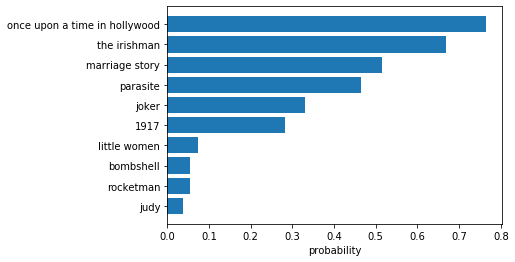

In [19]:
mlp = MLPClassifier(solver='sgd')
mlp_bag = BaggingClassifier(base_estimator=mlp, n_estimators=100, random_state=42).fit(X, y)
y_pred = mlp_bag.predict(X_2019)
y_prob = mlp_bag.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_mlpbag'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_mlpbag', ascending=False).head(10)
x = x.iloc[::-1,:]


### Performance evaluation
mlp_bag.fit(X_train, y_train)
y_pred = mlp_bag.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
plt.barh(x['title'], x['predicted_probability_mlpbag'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

acc_score = mlp_bag.score(X, y)
prec_score = precision_score(y_test, y_pred, labels= 'class 1')
print("Accuracy:", acc_score)
print("Precision:",prec_score)
name.append('mlp_bag')
precision.append(prec_score)
accuracy.append(acc_score)
print(name, accuracy, precision)

In [20]:
print(name)
print(accuracy)
print(precision)
print(recall)


['logreg', 'knn', 'rfc', 'bag', 'ada', 'mlp', 'mlp_bag']
[0.9817392272575437, 0.980625765504955, 0.9923171139071373, 0.9766173031956352, 0.9841888431132391, 0.9799576884534016, 0.9782874958245185]
[0.7164179104477612, 0.5769230769230769, 0.6779661016949152, 0.7575757575757576, 0.6463414634146342, 0.7088607594936709, 0.8372093023255814]
[]


In [21]:
performance_df = pd.DataFrame({'classifier': name, 'accuracy':accuracy, 'precision':precision})
performance_df.set_index('classifier', inplace=True)
performance_df
pickle.dump(performance_df,open('my_data/performance_df', "wb" ))
print(performance_df)

            accuracy  precision
classifier                     
logreg      0.981739   0.716418
knn         0.980626   0.576923
rfc         0.992317   0.677966
bag         0.976617   0.757576
ada         0.984189   0.646341
mlp         0.979958   0.708861
mlp_bag     0.978287   0.837209


# Grand Average Prediction

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

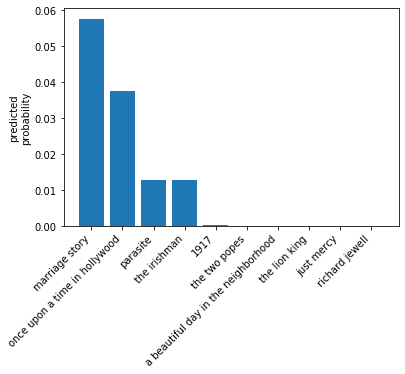

In [22]:


field = 'accuracy'
DFX_2019['final_proba'] = 1
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_log']*performance_df.loc['logreg',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_knn']*performance_df.loc['knn',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_rfc']*performance_df.loc['rfc',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_bag']*performance_df.loc['bag',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_ada']*performance_df.loc['ada',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlp']*performance_df.loc['mlp',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlpbag']*performance_df.loc['mlp_bag',field] 





DFX_2019.columns
x = DFX_2019.sort_values(by='final_proba', ascending=False).head(10)
# print(bag.best_params_)
# x = x.iloc[::-1,:]
plt.bar(x['title'], x['final_proba'])
plt.xticks(rotation=90)
plt.ylabel('predicted\nprobability')
plt.xticks(rotation=45, horizontalalignment = 'right')



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

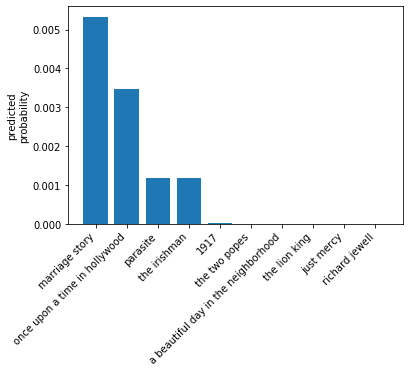

In [23]:


field = 'precision'
DFX_2019['final_proba'] = 1
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_log']*performance_df.loc['logreg',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_knn']*performance_df.loc['knn',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_rfc']*performance_df.loc['rfc',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_bag']*performance_df.loc['bag',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_ada']*performance_df.loc['ada',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlp']*performance_df.loc['mlp',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlpbag']*performance_df.loc['mlp_bag',field] 





DFX_2019.columns
x = DFX_2019.sort_values(by='final_proba', ascending=False).head(10)
# print(bag.best_params_)
# x = x.iloc[::-1,:]
plt.bar(x['title'], x['final_proba'])
plt.xticks(rotation=90)
plt.ylabel('predicted\nprobability')
plt.xticks(rotation=45, horizontalalignment = 'right')





# Deep Learning Prediction

In [24]:
print(X.shape)
print(y.shape)
print(type(X.values))
print(type(np.array(y)))
len(y[np.where(y==0)])
y[1:10]
X.values[3,]

(8981, 25)
(8981, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([1.0, 0.8, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
       1.0, 0.0, 0.0, 0.0, 0.008187845894714328, 0.7325581395348837,
       0.6702127659574467, 0.63, 0.3333333333333333, 0.18181818181818182,
       0.0, 0.0625], dtype=object)

In [25]:

# model = Sequential()
# model.add(Dense(32, input_dim=784))
# model.add(Activation('relu'))

import tensorflow as tf
import tensorflow.keras.backend as K

X_k = K.constant(X.values)
X_2019_k = K.constant(X_2019.values)
y_k = K.constant(y)

ndim = X.shape[1]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu, input_dim=ndim))
model.add(tf.keras.layers.Dense(36, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax))
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
# model.fit(X, y, epochs = 5)
model.fit(X_k, y_k, epochs = 5)
y_pred = model.predict([X_2019_k])

             

Train on 8981 samples
Epoch 1/5
8981/8981 [==============================] - 0s 54us/sample - loss: 0.1502 - accuracy: 0.9508
Epoch 2/5
8981/8981 [==============================] - 0s 32us/sample - loss: 0.0528 - accuracy: 0.9786
Epoch 3/5
8981/8981 [==============================] - 0s 32us/sample - loss: 0.0491 - accuracy: 0.9795
Epoch 4/5
8981/8981 [==============================] - 0s 32us/sample - loss: 0.0468 - accuracy: 0.9805
Epoch 5/5
8981/8981 [==============================] - 0s 31us/sample - loss: 0.0454 - accuracy: 0.9805


Text(0.5, 0, 'probability')

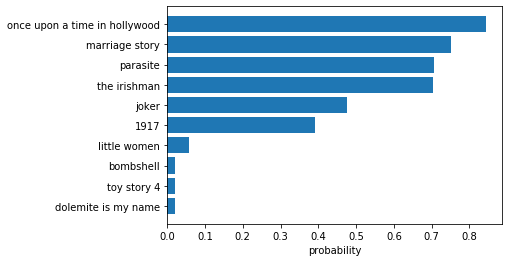

In [26]:
y_prob = y_pred
DFX_2019.loc[:,'predicted_probability_deep'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_deep', ascending=False).head(10)
x = x.iloc[::-1,:]

## Performance evaluation
plt.barh(x['title'], x['predicted_probability_deep'])
plt.xlabel('probability')


In [27]:
y_pred = mlp_bag.predict(X_2019)
